# Experiment 3.  Kanitza visibility analysis (Fig. 4CD).

In [2]:
# importing prerequisites
import os
import pandas as pd
import numpy as np
from scipy.stats import sem, wilcoxon
from scipy.stats.mstats import mquantiles
import matplotlib.pyplot as plt
import matplotlib
import pymc as pm
%matplotlib inline

### Loading  results and computing the disappearance time fraction

In [3]:
### loading raw results and computing duration of individual event
results= pd.read_csv(os.path.join('Experiment 3', 'Experiment3.csv'), sep=';')
results.Time= results.Time/1000.0 # milliseconds to seconds
results['Duration']= np.nan

for iRow in range(len(results)):
    if results.Event[iRow]==0: # onset event, we add duration to it
        for iFollowingRow in range(iRow+1, len(results)):
            if results.Block[iFollowingRow]!= results.Block[iRow]:
                print('Panic! Could not find the end of the event within the block!')
            if results.Event[iFollowingRow]==1 and results.Target[iFollowingRow]==results.Target[iRow]: # end event
                results.set_value(iRow, 'Duration', results.Time[iFollowingRow]-results.Time[iRow])
                break
results['EndTime']= results.Time+results.Duration
results['TimeMS']= results.Time*1000
results['EndTimeMS']= results.EndTime*1000

# removing early static masks condition
results= results[np.abs(results.RotationSpeed)>0]

In [4]:
# computing fraction of time for Kanitza visibility (Target==0) and for pacmen disappearance (Target==2)
FractionOfTimePerBlock= results[results.Event==0].groupby(['ID', 'MasksN', 'Block']).apply(
    lambda x: pd.Series({
            'KanitzaVisibility': x[x.Target==0].Duration.sum()/x.BlockDuration.values[0],
            'DisappearanceFraction': x[x.Target>0].Duration.sum()/x.BlockDuration.values[0]
        })).reset_index()

FractionOfTime= FractionOfTimePerBlock.groupby(['ID', 'MasksN']).apply(
    lambda x: pd.Series({
            'KanitzaVisibility': x.KanitzaVisibility.mean(),
            'DisappearanceFraction': x.DisappearanceFraction.mean()
        })).reset_index()
FractionOfTime['KanitzaForFullVisibility']= FractionOfTime.KanitzaVisibility/(1-FractionOfTime.DisappearanceFraction)

### Using Bayesian approach to fit linear regression for the effect of the mask number on visibility of the illusory Kanitza triangle

In [8]:
### converting table to a matrix, normalizing each observer to their overall means, but adding the overall average to keep condition means correct
FractionOfTime['MasksN']= FractionOfTime.MasksN.astype(int)
FractionOfTime['ConditionCode']= FractionOfTime.MasksN.astype(int)
matrix_like_df= FractionOfTime.pivot(index='ID', columns= 'ConditionCode', values='KanitzaVisibility').reset_index()
fraction_matrix= np.array(matrix_like_df)[:, 1:]

## Adjusting observers' means following Loftus & Masson (1994)
observer_average= np.mean(fraction_matrix, axis=1)
condition_average= np.mean(fraction_matrix, axis=0)
adjusted_matrix= fraction_matrix-np.tile(observer_average, (2, 1)).T+np.tile(np.mean(fraction_matrix), (observer_average.shape[0], 2))
adjusted_matrix= adjusted_matrix.astype(float)
condition_labels= np.array(matrix_like_df.columns[1:])

# factors presence for each condition
Mask= np.array([1, 0]) # mask factor

# data and data shape (for forming the fitted data)
data_shape= (adjusted_matrix.shape[0],1)
intercept_shape= adjusted_matrix.shape
data=adjusted_matrix

# variance around the linear regressor
sigma = pm.Exponential('sigma', beta=1.) 

# regression parameters
intercept     = pm.Uniform('intercept', -1e20, 1e20, value=0.5)
factorMask  = pm.Uniform('factorMask', -1e20, 1e20)
 
@pm.deterministic(plot=False)
def linear_fit_mask(intercept=intercept, factorMask=factorMask, Mask=Mask, data_shape=data_shape):
    return np.tile(intercept+factorMask*Mask, data_shape)

# defining models
yMask= pm.Normal('yMask', mu=linear_fit_mask, tau=1.0/sigma**2, value=adjusted_matrix, observed=True)
modelMask = pm.Model([yMask, sigma, intercept, factorMask])

print('Mask:')                   
map_ = pm.MAP(modelMask)
map_.fit()
mcmcMask = pm.MCMC(modelMask)
mcmcMask.sample(120000, 100000, 2)
print()

Mask:
 [-----------------100%-----------------] 120000 of 120000 complete in 13.6 sec


### Using fitted interaction model to predict values

In [9]:
### computing mean ± S.E.M. of predicted values for each condition

# getting posterior distributions for individual factors and their interaction  
InterceptDist= mcmcMask.trace('intercept')[:]
MaskDist= mcmcMask.trace('factorMask')[:]

# factors presence for each condition
Mask= np.array([1, 0]) # mask factor

# preparing arrays
predicted_mean= np.zeros(Mask.shape)
predicted_sem= np.zeros(Mask.shape)

# linear fit with an interaction term
def linear_fit_mask(intercept, factorMask, Mask):
    return intercept+factorMask*Mask

# computing distribution of predicted values for each condition
for iCond in range(len(Mask)):
    current_condition_dist= linear_fit_mask(InterceptDist,MaskDist,Mask[iCond])
    predicted_mean[iCond]= np.mean(current_condition_dist)
    predicted_sem[iCond]= np.std(current_condition_dist)

### Plotting the experimental results and model fits alongside with posterior distribution for mask factor (Fig. 4CD in the manuscript).

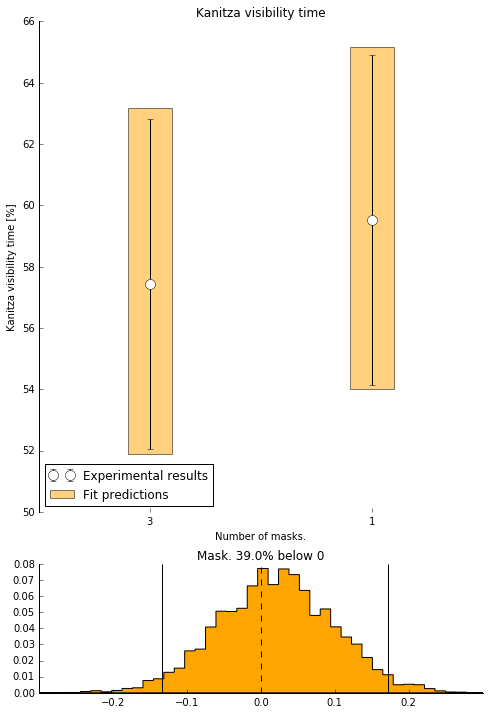

In [10]:
### plotting results
condition_order= [1, 0]

matplotlib.rcParams['figure.figsize'] = (7.0, 10.0)
ax= plt.subplot2grid((4,1), (0, 0), rowspan=3)
data_plot= plt.errorbar(condition_order, 
             np.mean(adjusted_matrix, axis=0)*100,
             yerr=sem(adjusted_matrix)*100,
             fmt= 'ko',
             markersize= 10,
             markerfacecolor = 'white')

for iCond in range(len(predicted_mean)):
    fit_plot= plt.fill_between(condition_order[iCond]+np.array([-0.1, 0.1]),
                     100*(predicted_mean[iCond]-predicted_sem[iCond]+np.zeros((2, ))),
                     100*(predicted_mean[iCond]+predicted_sem[iCond]+np.zeros((2, ))),
                     facecolor='orange', alpha= 0.5)
                     
plt.xticks(condition_order, condition_labels)
current_axis= plt.axis()
plt.axis([-0.5, 1.5, current_axis[2], current_axis[3]])
plt.legend(handles= [data_plot, fit_plot], labels=['Experimental results', 'Fit predictions'], loc='lower left')
plt.ylabel('Kanitza visibility time [%]')
plt.xlabel('Number of masks.')
plt.title('Kanitza visibility time')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax= plt.subplot2grid((4,1), (3, 0))
plt.hist(MaskDist, bins=50, histtype="stepfilled", weights=np.ones(MaskDist.shape)/MaskDist.shape[0], color='orange')
current_axis= plt.axis()
plt.vlines(np.percentile(MaskDist, [2.5, 97.5]), 0, current_axis[3], color='black')
plt.vlines([0], 0, current_axis[3], color='black', linestyles=['dashed'])
plt.title('Mask. %.1f%% below 0'%(100*np.sum(MaskDist<0)/MaskDist.shape[0]))
plt.axis([-0.30, 0.30, 0, current_axis[3]])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tight_layout()
plt.show()